In [1]:
from pathlib import Path
import sys

sys.path.append(str(Path('').absolute().parent))

In [2]:
import json
import math
import numpy as np
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.morgan_handler import get_morgan_fingerprints
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import (Draw,
                        Descriptors,
                        AllChem)
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import umap
import itertools as it
import warnings


warnings.filterwarnings("ignore")

# Exploração dos bits do conjunto de dados

In [3]:
morgan_fp, df_labels = get_morgan_fingerprints()

In [4]:
morgan_fp.shape

(5175, 2048)

In [5]:
df_labels.head(10)

,labels,chembl_ids,fingerprint_id
0,1,CHEMBL301018,0
1,1,CHEMBL281543,1
2,1,CHEMBL401930,2
3,0,CHEMBL274654,3
4,1,CHEMBL382822,4
5,0,CHEMBL447230,5
6,0,CHEMBL119987,6
7,1,CHEMBL213874,7
8,1,CHEMBL53665,8
9,1,CHEMBL554566,9


Contando o número de moléculas associadas a cada uma das labels, podemos observar que há quase o dobro de inibidores em relação aos não inibidores.

In [6]:
df_labels['labels'].value_counts()

1    3553
0    1622
Name: labels, dtype: int64

## Histograma de Frequência de ativação de bits

Esse histograma mostra como é a distribuição da frequência de ativação dos bits.

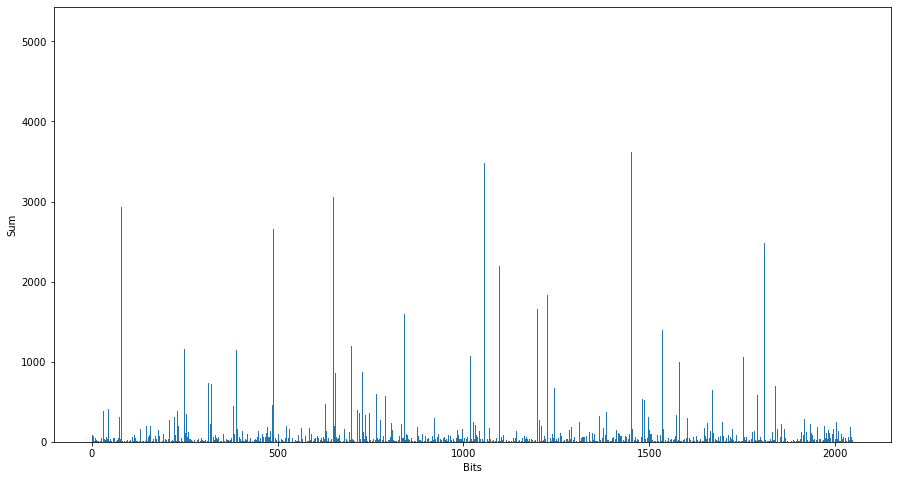

In [7]:
fig = plt.figure(figsize=(15,8))
sum_bits = morgan_fp.sum(axis=0)
plt.bar(list(range(sum_bits.shape[0])), sum_bits)
plt.xlabel('Bits')
plt.ylabel('Sum')
plt.show()

## Separação dos dados em treino e teste

Antes de proceder com análises mais aprofundadas, é boa prática já separar parte do conjunto de dados para teste, e nãp usar esses dados em análise em exploratória nem para modelagem. Assim, evitamos criar viéses sobre como os dados deveriam se comportar.

In [8]:
# configurar seed para reproducibilidade
SEED = 123
np.random.seed(SEED)

In [9]:
y = df_labels['labels'].values.copy()
X = morgan_fp.copy()

In [10]:
# estratificando por y para garantir distribuição de treino e
# teste semelhantes
test_size = 0.2
train_X, test_X, train_y, test_y = \
    train_test_split(X, y, test_size=test_size, stratify=y, random_state=SEED)

In [11]:
paths_ds = [('../data/raw/{}/sparse_{}.npz'.format(ds_name.split('_')[0], ds_name), ds_name)
            for ds_name in ['train_X', 'train_y', 'test_X', 'test_y']]
paths_ds

[('../data/raw/train/sparse_train_X.npz', 'train_X'),
 ('../data/raw/train/sparse_train_y.npz', 'train_y'),
 ('../data/raw/test/sparse_test_X.npz', 'test_X'),
 ('../data/raw/test/sparse_test_y.npz', 'test_y')]

In [12]:
for path, ds_name in paths_ds:
    path = Path(path)
    if not path.exists():
        print('Saving {} to {} ...'.format(ds_name, path))
        sparse_arr = sparse.csr_matrix(eval(ds_name))
        sparse.save_npz(path, sparse_arr)
    else:
        print('File already exists. Skipping ...')

File already exists. Skipping ...
File already exists. Skipping ...
File already exists. Skipping ...
File already exists. Skipping ...


## Bits mais ativados entre os inibidores e entre os não inibidores

O histograma abaixo ilustra a frequência relativa média de vezes que cada bit é ativado por proteínas inibidoras e não inibidoras.

In [13]:
features = train_X

inhibitors_mean_activation = train_X[train_y == 1].mean(axis=0)
non_inhibitors_mean_activation = train_X[train_y == 0].mean(axis=0)

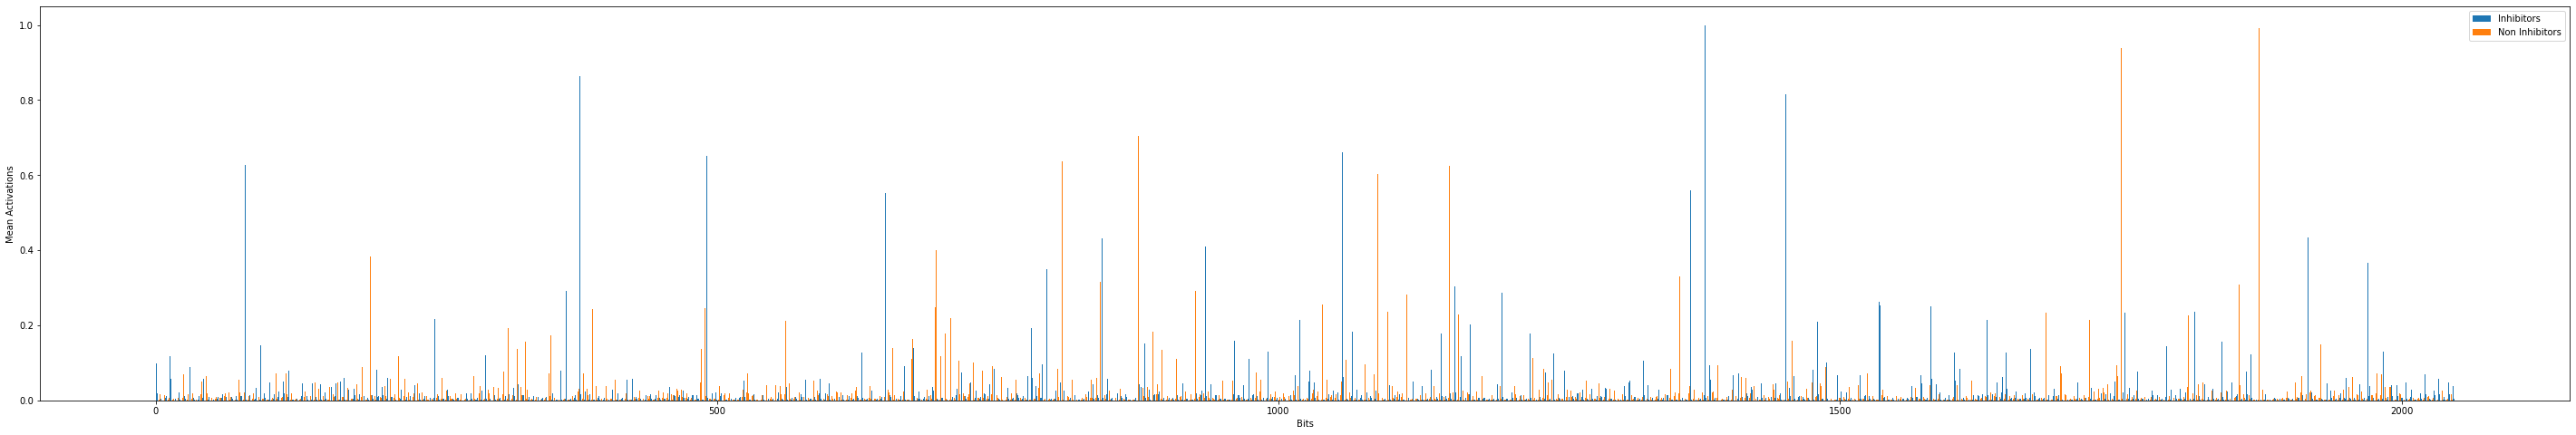

In [14]:
fig, ax = plt.subplots(figsize=(50,8))
n = 2048
x = np.arange(n)
width = 0.4
bar1 = ax.bar(x - width/2, inhibitors_mean_activation, width, label='Inhibitors')
bar2 = ax.bar(x + width/2, non_inhibitors_mean_activation, width, label='Non Inhibitors')

ax.set_xlabel('Bits')
ax.set_ylabel('Mean Activations')
ax.legend()
plt.show()

Quais são os bits mais frequetemente ativados entre os inibidores?

In [15]:
indices = np.array(list(range(inhibitors_mean_activation.shape[0])))

inhibitors_indices = indices[inhibitors_mean_activation > 0.2]

print('Most activated bits on inhibitors', inhibitors_indices)

Most activated bits on inhibitors [  80  191  249  329  366  378  389  489  491  561  650  673  694  695
  699  703  708  728  794  807  841  843  875  888  926  935 1019 1039
 1057 1088 1097 1152 1157 1171 1199 1226 1357 1367 1380 1452 1480 1535
 1536 1581 1631 1683 1750 1754 1810 1816 1855 1873 1917 1928 1970]


Quais são os bits mais frequetemente ativados entre os não inibidores?

In [16]:
non_inhibitors_indices = indices[non_inhibitors_mean_activation > 0.2]

print('Most activated bits on non inhibitors', non_inhibitors_indices)

Most activated bits on non inhibitors [  80  191  249  378  389  489  491  561  650  694  695  708  807  841
  843  875  926  935 1039 1057 1088 1097 1114 1152 1160 1171 1199 1357
 1380 1452 1536 1683 1722 1750 1810 1816 1855 1873 1917 1970]


Queremos saber quais são os bits mais ativados apenas dentre os inibidores. Portanto, vamos criar uma lista com os índices desses bits.

In [17]:
bits_inhibitors_only = sorted(list(set(inhibitors_indices) - set(non_inhibitors_indices)))
print(bits_inhibitors_only)

[329, 366, 673, 699, 703, 728, 794, 888, 1019, 1157, 1226, 1367, 1480, 1535, 1581, 1631, 1754, 1928]


In [18]:
bits_non_inhibitors_only = list(set(non_inhibitors_indices) - set(inhibitors_indices))
print(bits_non_inhibitors_only)

[1160, 1722, 1114]


In [19]:
with open('../data/bit_info.json', 'r') as file:
    chembl_to_bitinfo = json.load(file)

In [20]:
df_smiles = pd.read_csv('../data/egfr_erbB1_smiles.csv', index_col=0)
df_smiles

,chembid,smiles_notation
0,CHEMBL301018,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OC
1,CHEMBL281543,C=CC(=O)Nc1nc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1CCCCN...
2,CHEMBL401930,Cc1cc(N2CCOCC2)cc2[nH]c(-c3c(NC[C@@H](O)c4cccc...
3,CHEMBL274654,Cc1[nH]c(/C=C2\C(=O)Nc3ccccc32)c(C)c1CCC(=O)O
4,CHEMBL382822,COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC[C@@H]1C...
...,...,...
5173,CHEMBL1645470,Cc1cccc(Nc2ncnn3ccc(CN4CCC(N)CC4)c23)c1
5174,CHEMBL1683960,Cc1ncnc(Nc2ccc(OCc3cccc(F)c3)c(Cl)c2)c1-c1cccc...
5175,CHEMBL1765740,CNc1nc(-c2ccc3c(N)n[nH]c3c2)cc(N2C[C@@H](C(=O)...
5176,CHEMBL112225,COc1cc2ncc(C#N)c(Nc3cccc(Br)c3C)c2cc1OC


In [21]:
chembl_inhibitors = df_labels['chembl_ids'][df_labels['labels'] == 1]
chembl_non_inhibitors = df_labels['chembl_ids'][df_labels['labels'] == 0]

In [22]:
df_smiles_non_inhibitors = df_smiles[df_smiles['chembid'].isin(chembl_non_inhibitors)]
df_smiles_inhibitors = df_smiles[df_smiles['chembid'].isin(chembl_inhibitors)]
df_smiles_inhibitors

,chembid,smiles_notation
0,CHEMBL301018,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OC
1,CHEMBL281543,C=CC(=O)Nc1nc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1CCCCN...
2,CHEMBL401930,Cc1cc(N2CCOCC2)cc2[nH]c(-c3c(NC[C@@H](O)c4cccc...
4,CHEMBL382822,COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC[C@@H]1C...
7,CHEMBL213874,COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1OCC1CCN(C)CC1
...,...,...
5172,CHEMBL1630111,Nc1ccccc1NC(=O)c1ccc(-c2ccc3ncnc(Nc4ccc(OCc5cc...
5173,CHEMBL1645470,Cc1cccc(Nc2ncnn3ccc(CN4CCC(N)CC4)c23)c1
5174,CHEMBL1683960,Cc1ncnc(Nc2ccc(OCc3cccc(F)c3)c(Cl)c2)c1-c1cccc...
5176,CHEMBL112225,COc1cc2ncc(C#N)c(Nc3cccc(Br)c3C)c2cc1OC


In [23]:
# funções de conveniência
def get_mol(chembl, df_smiles):
    smiles = df_smiles[df_smiles['chembid'] == chembl].iloc[0,1]
    mol = Chem.MolFromSmiles(smiles)
    return mol

def plot_activated_bit(chembl, bit_index, df_smiles):
    mol = get_mol(chembl, df_smiles)
    bit_info = chembl_to_bitinfo[chembl]        
    if not bit_info.get(str(bit_index), None):        
        return None
    
    mgfp_bit = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2,
                                                      nBits=2048,
                                                      bitInfo=bit_info)

    svg = Draw.DrawMorganBit(mol, bit_index, bit_info, useSVG=True)
    return svg

## Trechos de moléculas que ativam bits de inibidores

Aqui plotamos os trechos relacionados a bits ativados com frequência por inibidores.

Mecule: CHEMBL301018  -- bit index: 329


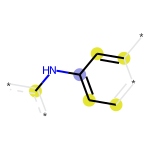

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL281543  -- bit index: 366


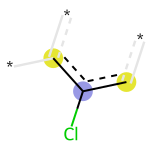

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL382822  -- bit index: 673


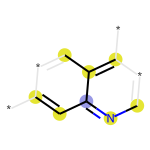

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL213874  -- bit index: 699


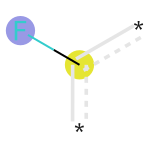

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL128468  -- bit index: 703


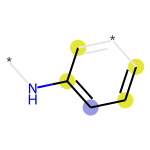

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL53665  -- bit index: 728


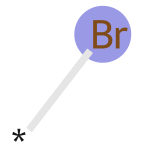

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL385471  -- bit index: 794


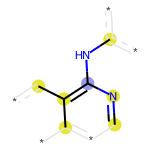

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL66570  -- bit index: 888


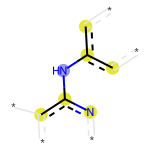

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL25425  -- bit index: 1019


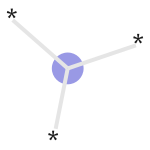

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL401930  -- bit index: 1157


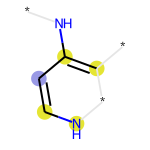

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL554566  -- bit index: 1226


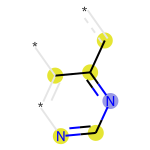

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL35820  -- bit index: 1367


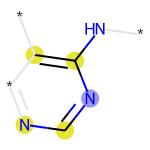

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL939  -- bit index: 1480


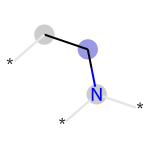

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL113901  -- bit index: 1535


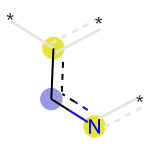

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL55979  -- bit index: 1581


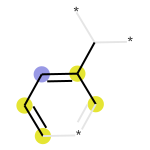

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL29197  -- bit index: 1631


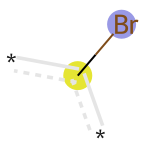

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL243628  -- bit index: 1754


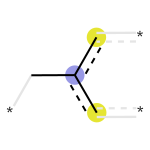

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL31373  -- bit index: 1928


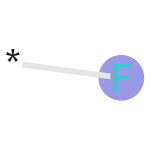

----------------------------------------------------------------------------------------------------


In [24]:
for index in bits_inhibitors_only:       
    for chembid in df_smiles_inhibitors['chembid']:                
        # display(Draw.MolToImage(get_mol(chembid)))
        img = plot_activated_bit(chembid, index, df_smiles_inhibitors)
        if img:
            print('Mecule:', chembid, ' -- bit index:', index)
            display(img)
            break
    
    print('-'*100)

## Trechos de moléculas que ativam bits de não inibidores

Aqui plotamos os trechos relacionados a bits ativados com frequência por não inibidores.

Mecule: CHEMBL67424  -- bit index: 1160


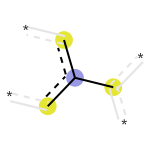

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL274654  -- bit index: 1722


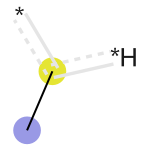

----------------------------------------------------------------------------------------------------
Mecule: CHEMBL89646  -- bit index: 1114


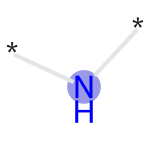

----------------------------------------------------------------------------------------------------


In [25]:
for index in bits_non_inhibitors_only:       
    for chembid in df_smiles_non_inhibitors['chembid']:                
        # display(Draw.MolToImage(get_mol(chembid)))
        img = plot_activated_bit(chembid, index, df_smiles_non_inhibitors)
        if img:
            print('Mecule:', chembid, ' -- bit index:', index)
            display(img)
            break
    
    print('-'*100)

# Investigação de alternativas para redução de dimensionalidade

## Principal Component Anaysis (PCA)

Podemos usar a Análise de Componentes Principais diretamente sobre as _fingerprints_ com o intuito extrair caracterísiticas latetntes nos dados, formadas pela combinação linear de bits ativados. Essa idéia é baseada no [exemplo de extração de _eigenfaces_](https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py) do conjunto de dados de rostos da biblioteca Scikit-Learn.

Visualizando os componentes principais e a variância explicada acumulada:

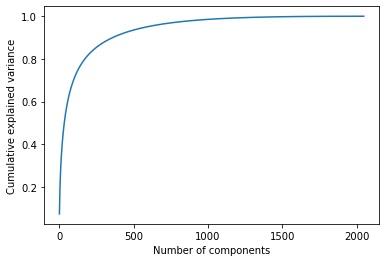

In [26]:
#Análise PCA das features da fingerprint
pca = PCA().fit(train_X)

#Visualização da quantidade de bits vs variância cumulativa do Dataset
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

In [27]:
# função para experimentação
def pca_reduce_dim(features, desired_variance):
    pca = PCA(desired_variance).fit(features)
    reduced = pca.transform(features)
    print('{} of variance explained by {} components'.format((desired_variance * 100), pca.n_components_))
    return reduced

In [28]:
# Número de componentes para tingimento de cada% da variância total
pca = PCA(0.50).fit(train_X)
print('50% of variance explained by {} components'.format(pca.n_components_))

pca = PCA(0.80).fit(train_X)
print('80% of variance explained by {} components'.format(pca.n_components_))

pca = PCA(0.95).fit(train_X)
print('95% of variance explained by {} components'.format(pca.n_components_))

50% of variance explained by 34 components
80% of variance explained by 173 components
95% of variance explained by 587 components


Visualizando com apenas dois componentes, com o intuito de varificar se parece existir algum padrão na aglomeração dos dados quando transformados.

In [29]:
pca_2d = PCA(n_components = 2).fit(train_X)
train_X_pca_2components = pca_2d.transform(train_X)

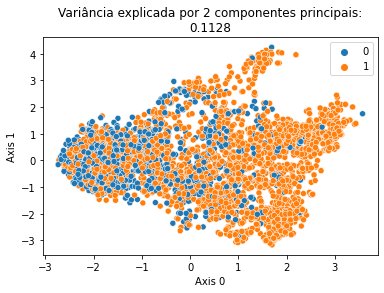

In [30]:
sns.scatterplot(x=train_X_pca_2components[:,0],
                y=train_X_pca_2components[:,1],
                hue=train_y)
plt.xlabel('Axis 0')
plt.ylabel('Axis 1')
plt.title('Variância explicada por 2 componentes principais:\n{:.4f}'
          .format(pca_2d.explained_variance_ratio_.sum()));

Mesmo com pouco mais que 11% da variância total explicada, dois componentes principais já parecem sugerir algum agrupamento entre moléculas inibidoras e não-inibidoras.

## Investigação de técnicas de _embedding_ para redução de dimensionalidade

A seguir, investigamos o uso da técnica [UMAP](https://umap-learn.readthedocs.io/en/latest/) como alternativa de _manifold learning_ para investigação da estrutura do espaço altamente multidmensional dos dados.

São testadas também duas abordagens de preprocessamento:
1. UMAP sobre: i) Todas os bits originais vs ii) combinação linear de bits usando PCA (redução de dimensão a priori)
2. i) Vetores de bit (_one-hot_) vs ii) com aplicação de normalizador (Modelo de Espaço Vetorial)

Para normalização dos dados, será utilizado o `Nomalizer` da biblioteca Scikit-Learn. De acordo com a [documentação](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization), essa abordagem para preprocessamento pode ser útil quando se busca quantificar a similaridade entre entre amostras baseando-se em medidas quadráticas, como o produto-escalar. É uma abordagem que se baseia no Modelo de Espaço Vetorial e é comumente utilizada em classificação de documentos e clusterização.

In [31]:
normalizer = Normalizer()
train_X_norm = normalizer.fit_transform(train_X)

In [32]:
param_grid = {
    'metric': ['cosine'],
    'n_neighbors': [5, 10, 20, 30],
    'min_dist': [0.1, 0.25, 0.5]
}

In [33]:
# função de conveniência
def plot_umap_embeddings(features, labels, param_grid, ncols):
    ks, vs = zip(*param_grid.items())
    param_combinations = [dict(zip(ks, v))
                          for v in it.product(*vs)]
    nrows = math.ceil(len(param_combinations)/ncols)
    fig, axs = plt.subplots(figsize=(ncols*5, nrows*6), nrows=nrows, ncols=ncols)
    for i, params in enumerate(param_combinations):
        reducer = umap.UMAP(**params)
        embeddings = reducer.fit_transform(features)

        # plot embeddings from unormalized, one-hot values 
        row, col = divmod(i, ncols)
        sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1],
                    hue=labels, cmap='Paired', ax=axs[row, col])
        axs[row, col].set_title('UMAP: {}'
                                .format('\n'.join(['{}: {}'.format(k, v) for k, v in params.items()])))

    plt.tight_layout()
    plt.show()

### Diretamente sobre todos os bits

**Dados não normalizados**

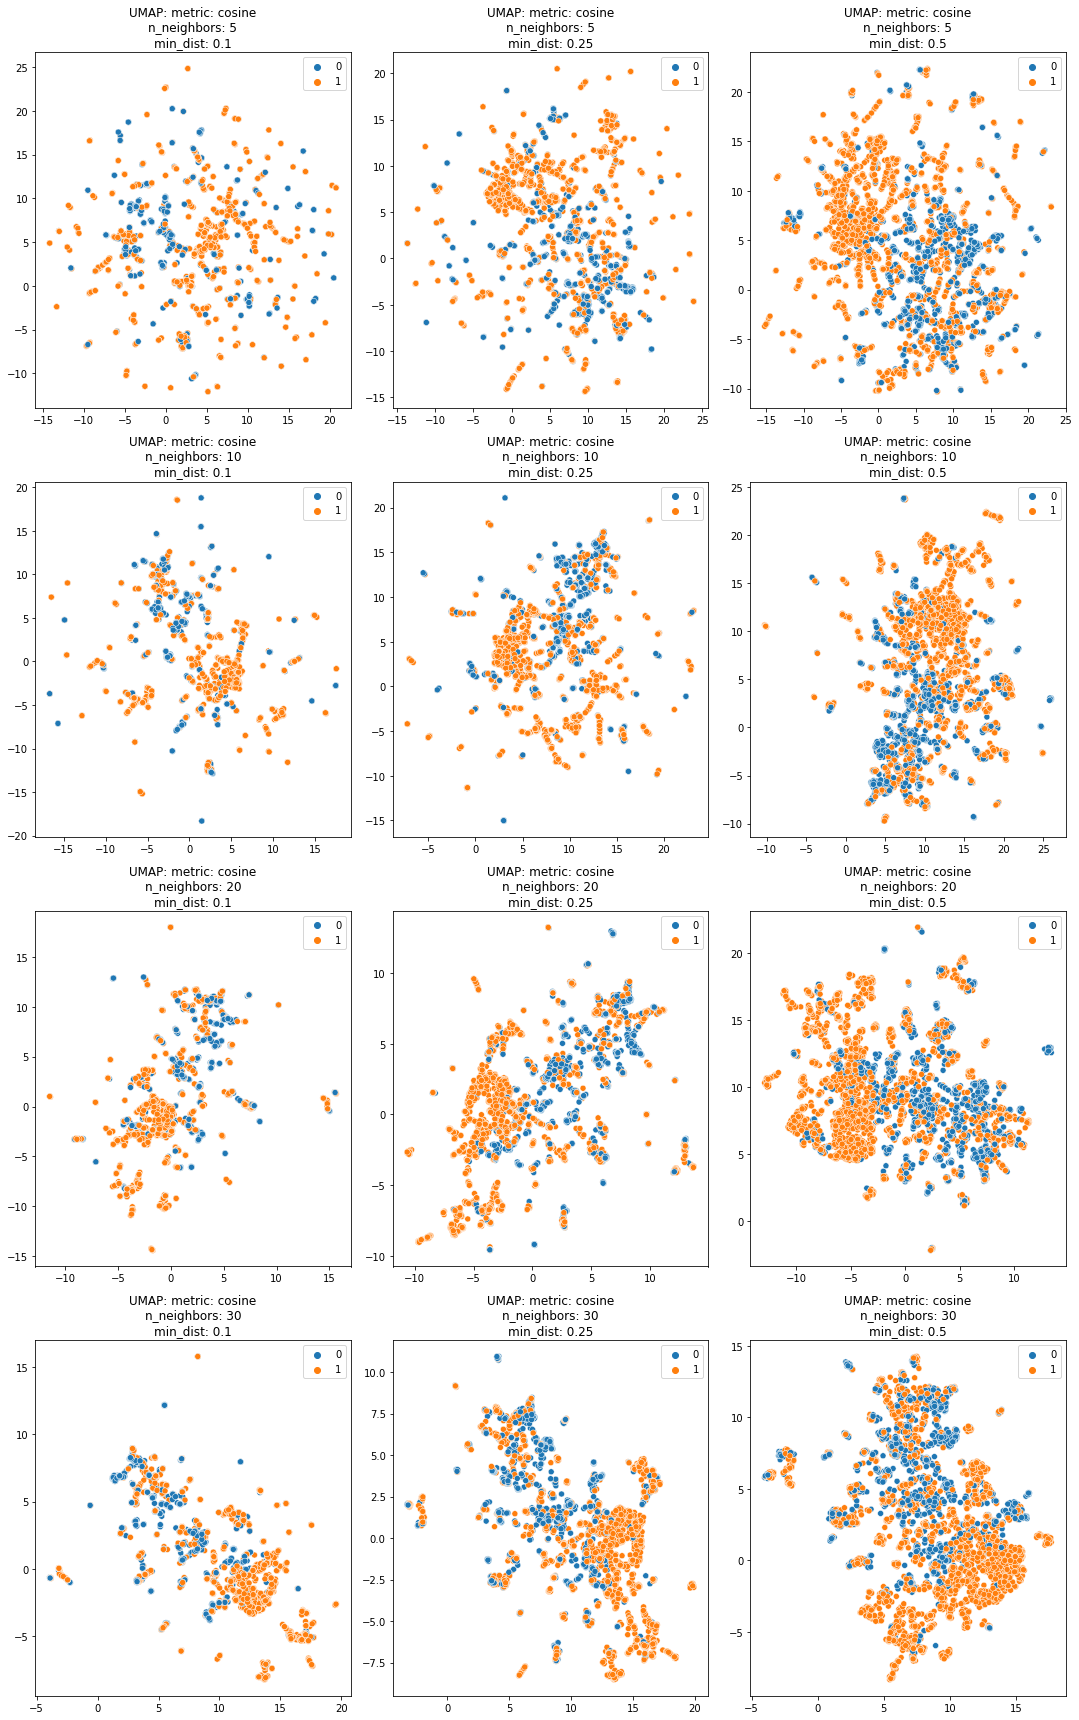

In [34]:
plot_umap_embeddings(train_X, train_y, param_grid, ncols=3)

**Dados normalizados**

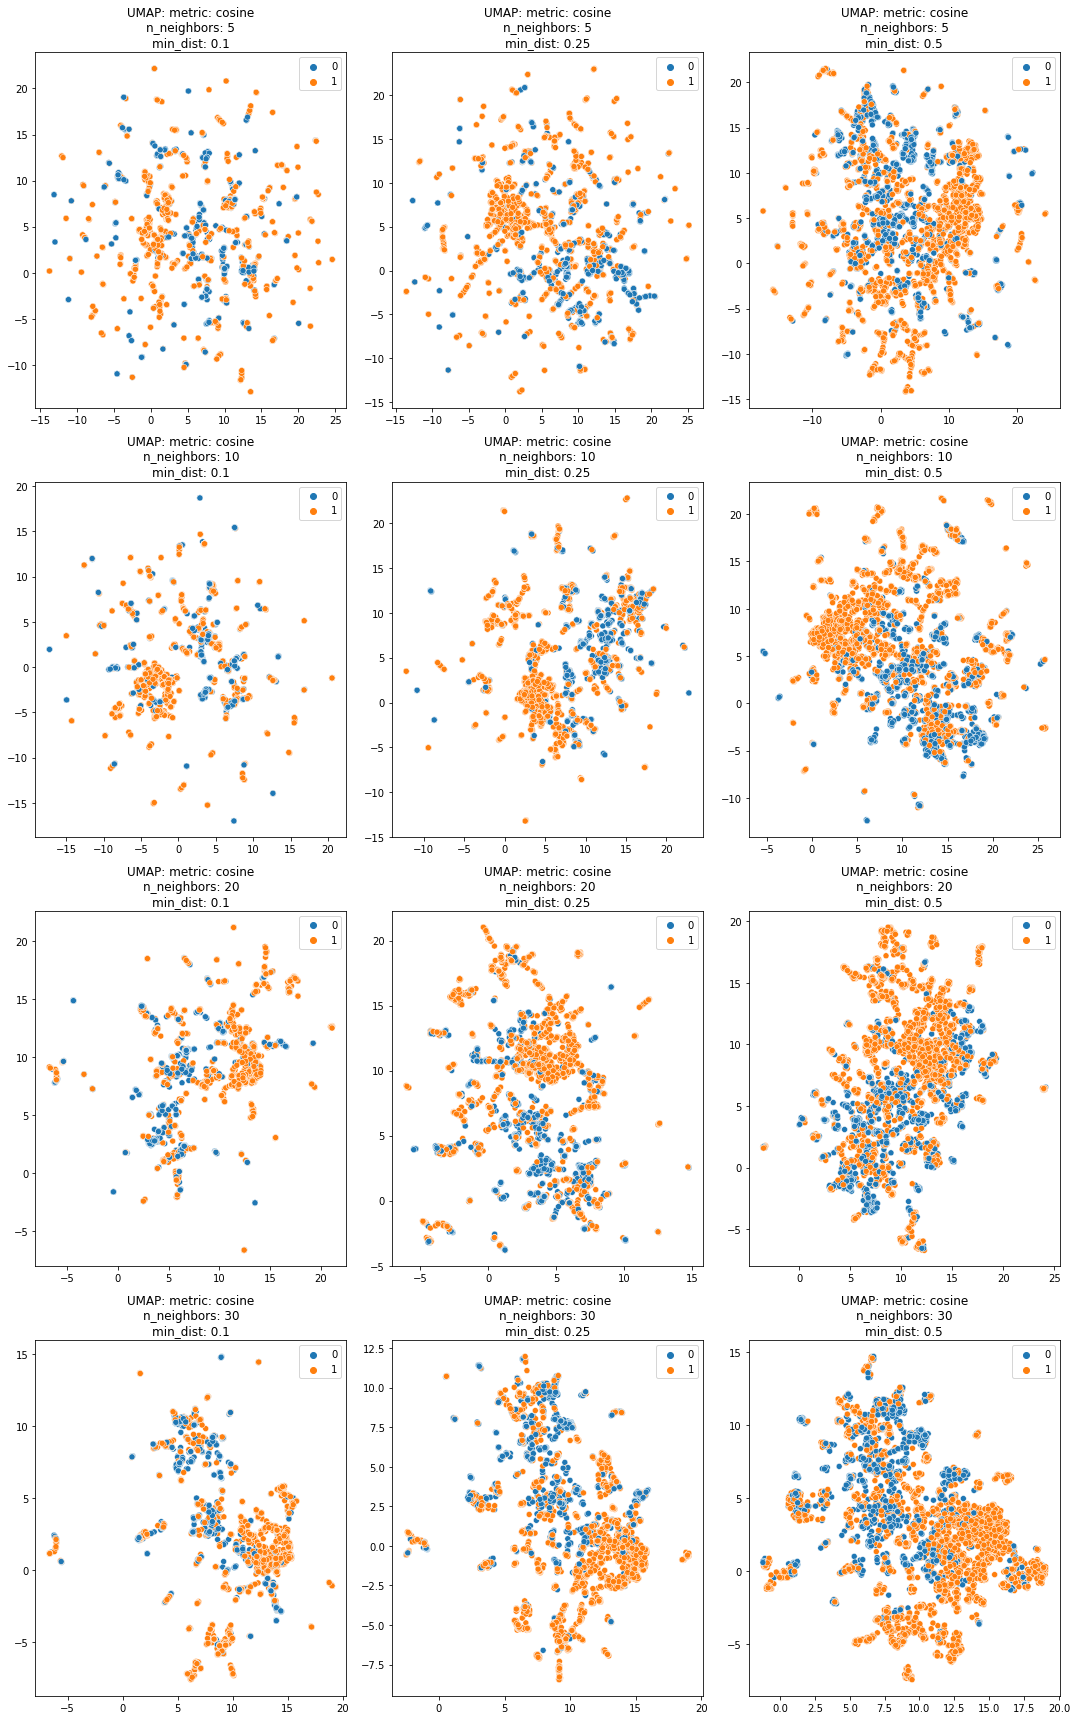

In [35]:
plot_umap_embeddings(train_X_norm, train_y, param_grid, ncols=3)

## Sobre componentes principais de bits

A título de ilustração, serão usados os primeiro 50 componentes principais.

In [36]:
# dados não normalizados
pca_raw = PCA(n_components=50)
train_X_pca = pca_raw.fit_transform(train_X)

# dados normalizados
pca_norm = PCA(n_components=50)
train_X_norm_pca = pca_norm.fit_transform(train_X_norm)

**Dados não normalizados**

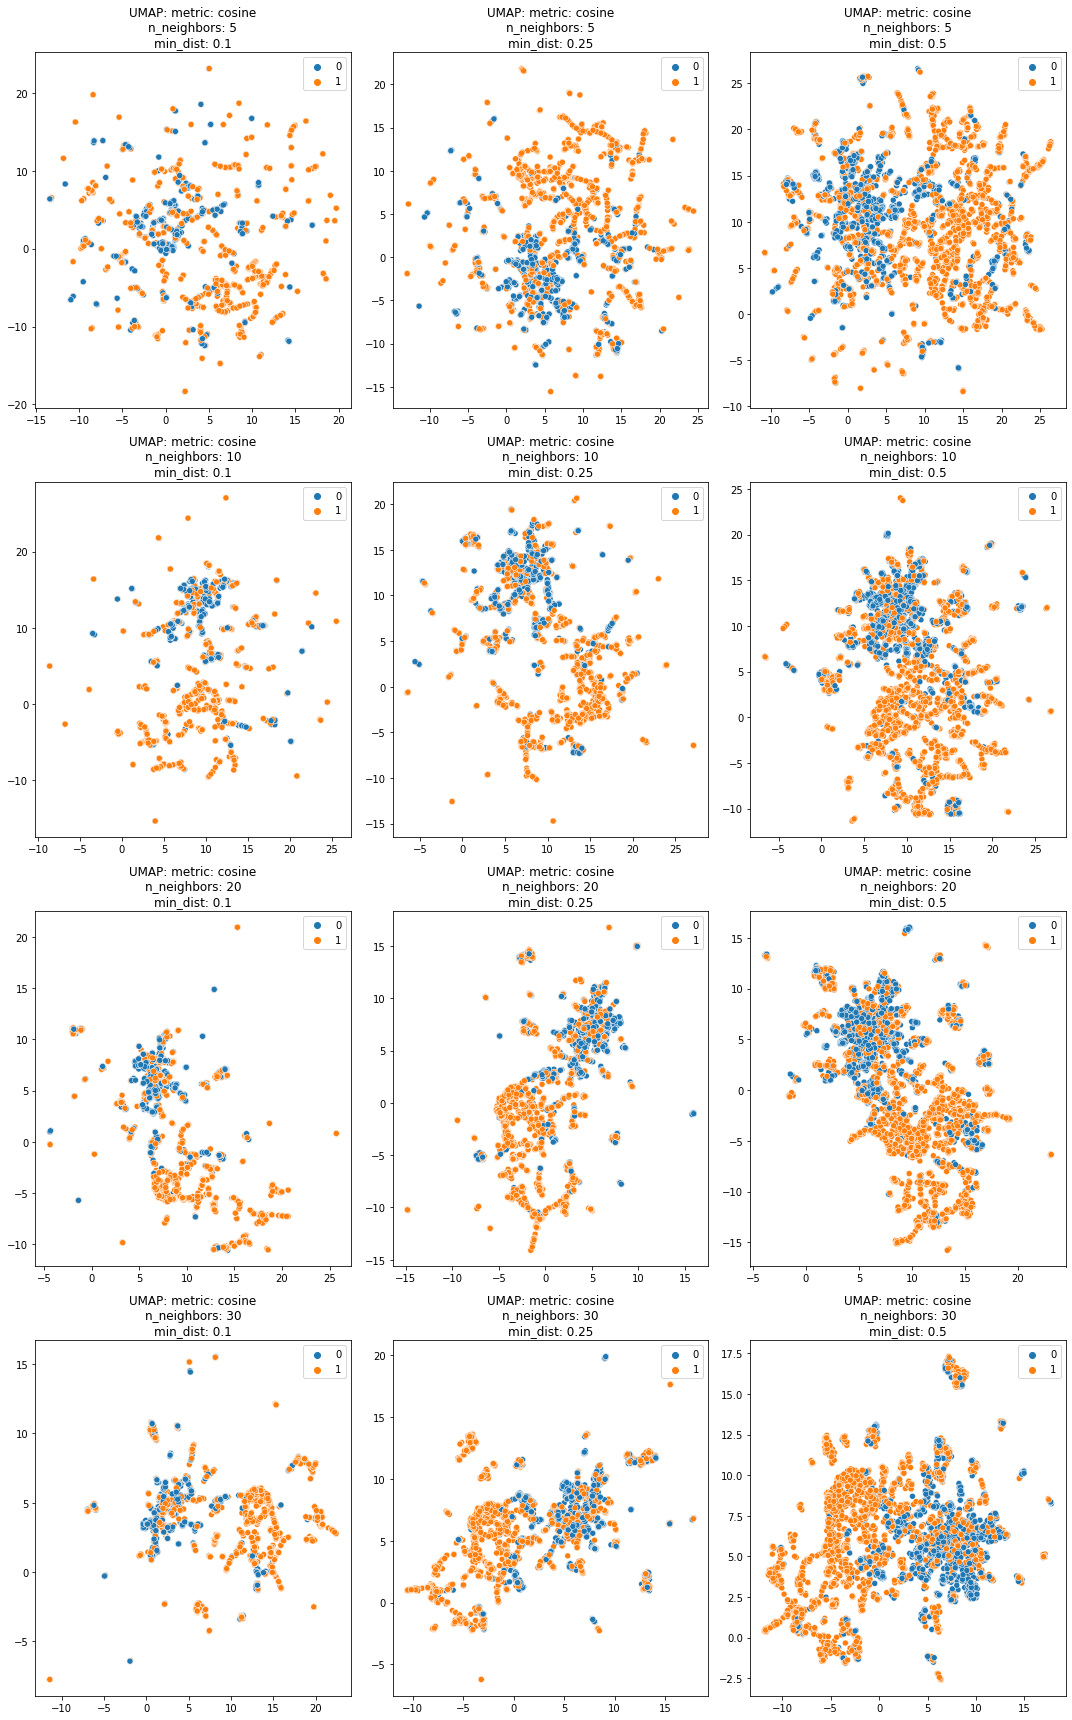

In [37]:
plot_umap_embeddings(train_X_pca, train_y, param_grid, ncols=3)

**Dados normalizados**

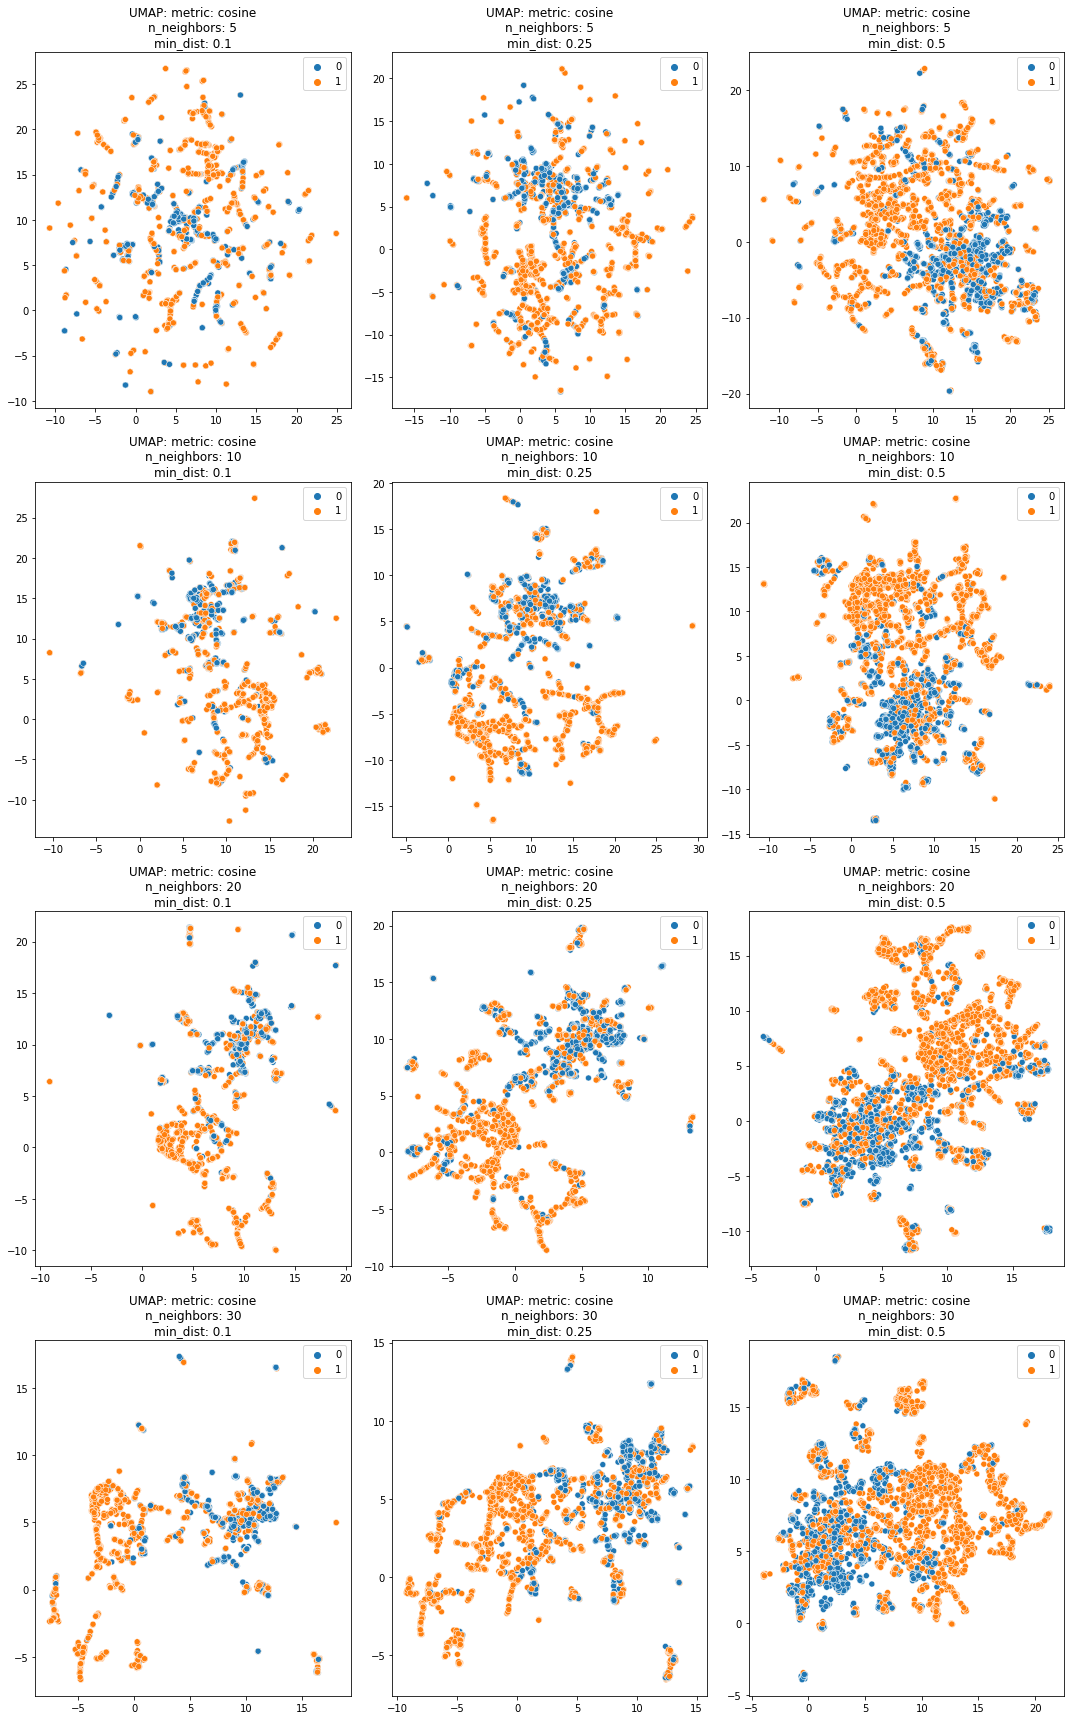

In [38]:
plot_umap_embeddings(train_X_norm_pca, train_y, param_grid, ncols=3)

Assim como observado anteriormente com a análise de 2 componentes do PCA nos dados originais, é possível visualizar alguma separação entre aglomerações de moléculas inibidoras e não inibidoras.
Muito interessante também verificar que para algumas combinações de preprocessamento (e.g. dados -> normalização -> 50 components principais -> umap: {'metric': 'cosine', 'n_neighbors': 30, 'min_dist': 0.5}) é possivel visualizar a formação de aglomerações "puras", isot é, que parecem formadas apenas por inibidores e não inibidores.

Isso nos dá esperança de que no espaço muldimensional, algoritmos de mineração de dados possam encontrar padrões em bits e suas intereações que resultem em uma boa predição.